# Extract data, list all available benchmarks

In [16]:
import pandas as pd
spec_data = pd.read_csv("benchmarks.txt")
print spec_data["benchName"].unique()

['101.tomcatv' '102.swim' '103.su2cor' '104.hydro2d' '107.mgrid'
 '110.applu' '125.turb3d' '141.apsi' '145.fpppp' '146.wave5' '099.go'
 '124.m88ksim' '126.gcc' '129.compress' '130.li' '132.ijpeg' '134.perl'
 '147.vortex' '168.wupwise' '171.swim' '172.mgrid' '173.applu' '177.mesa'
 '178.galgel' '179.art' '183.equake' '187.facerec' '188.ammp' '189.lucas'
 '191.fma3d' '200.sixtrack' '301.apsi' '164.gzip' '175.vpr' '176.gcc'
 '181.mcf' '186.crafty' '197.parser' '252.eon' '253.perlbmk' '254.gap'
 '255.vortex' '256.bzip2' '300.twolf' '400.perlbench' '401.bzip2' '403.gcc'
 '429.mcf' '445.gobmk' '456.hmmer' '458.sjeng' '462.libquantum'
 '464.h264ref' '471.omnetpp' '473.astar' '483.xalancbmk' '410.bwaves'
 '416.gamess' '433.milc' '434.zeusmp' '435.gromacs' '436.cactusADM'
 '437.leslie3d' '444.namd' '447.dealII' '450.soplex' '453.povray'
 '454.calculix' '459.GemsFDTD' '465.tonto' '470.lbm' '481.wrf'
 '482.sphinx3']


# Choose benchmark "179.art" and convert date to float format (in year unit)

In [17]:
from datetime import datetime

def to_year(s):
    """Convert a 'YYYYMMDD' string to a float 
    representing the year.
    """
    d = datetime.strptime(s, '%Y%m%d')
    ld = datetime.strptime(s[:4]+"1231", '%Y%m%d')
    return d.year+d.timetuple()[7]/float(ld.timetuple()[7])

bench1 = spec_data[spec_data["benchName"]=="179.art"].reset_index(drop=True)
bench1["year"] = [to_year(_.split('-')[1]) for _ in bench1["testID"]]
bench1.head()

,testID,benchName,base,peak,year
0,cpu2000-19991130-00002,179.art,211.0,NaN,1999.915068
1,cpu2000-19991130-00004,179.art,263.0,NaN,1999.915068
2,cpu2000-19991130-00006,179.art,1238.0,1564,1999.915068
3,cpu2000-19991130-00008,179.art,205.0,NaN,1999.915068
4,cpu2000-19991130-00010,179.art,759.0,900,1999.915068


# Plot data in semi-log plot

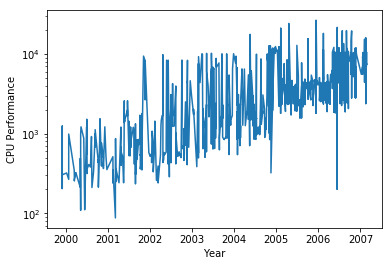

In [18]:
import matplotlib.pyplot as plt
X = bench1["year"].copy()
Y = bench1["base"].copy()
plt.semilogy(X, Y)
plt.ylabel("CPU Performance")
plt.xlabel("Year")
plt.show()

# Split data to training and testing set

In [19]:
import numpy as np
from random import shuffle
# Shuffle data for splitting purpose
data = zip(X, Y)
shuffle(data)
X, Y = zip(*data)
# Add one more dimension to X
X = np.array([[_] for _ in X])
# Prepare Y for linear regression by taking the log
Y = np.log2(Y)
# Split data
split_ratio = 0.8
cutoff = int(len(X)*split_ratio)
train_X = X[:cutoff]
train_Y = Y[:cutoff]
test_X = X[cutoff:]
test_Y = Y[cutoff:]

# Fit a linear model

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
model = LinearRegression()
model.fit(train_X, train_Y)
predicted = model.predict(test_X)
print "Coefficient =", model.coef_[0]
print "RMSE =", np.sqrt(mean_squared_error(test_Y, predicted))
print "R^2 =", r2_score(test_Y, predicted)

Coefficient = 0.615837748929
RMSE = 0.926728749549
R^2 = 0.620953603632


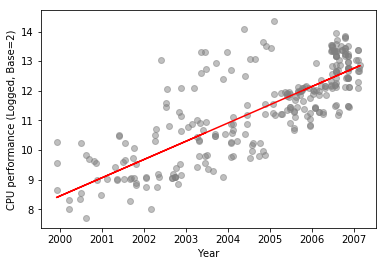

In [25]:
plt.scatter(test_X, test_Y, color="grey", alpha=0.5)
plt.plot(test_X, predicted, color="red")
plt.xlabel("Year")
plt.ylabel("CPU performance (Logged, Base=2)")
plt.show()

# How well is Moore's law holding up

Moore's law states that the number of transistors on integrated circuits doubles roughly every two years. Translating this to mathematical language, we have
$$ N = c \cdot 2^{\frac{1}{2}T}$$
where $N$ is the number of transistors, $T$ is the year, and $c$ is a constant. Note that this law only applies within certain domain of x (e.g. since the year integrated circuits were invented), and that in the equation the variables are real numbers whereas in reality the year and the number of transistors should be positive integers.

The fitted line has the equation
$$ y = b + 0.6158 * x $$

Assuming that the CPU performance and the number of transistors have a linear relation (with an intercept of zero), we have
$$ y = \log_2 (kN) $$
where $k$ is some constant. Then we have
$$ \log_2 (kN) = b + 0.6158 \cdot x$$
$$ kN = 2^{b + 0.6158 \cdot x}$$
$$ N = (\frac{1}{k}\cdot2^{b}) \cdot 2^{0.6158 \cdot x}$$

If we let $c$ be $\frac{1}{k}\cdot2^{b}$ and compare Moore's law to the equation above, we would see that the only difference is the coefficient inside the exponent. Since 0.6158 is quite close to 0.5, I would say that Moore's law is holding up fairly well.

Looking at R-square, we see that only around 62% of the variance in the data is explained by the model. This is reasonable since we know that there are a lot of variations among individual CPUs, depending their brands, models and productions, even within the same year. Looking at the plot, the linear relation is quite convincing, and will be more obvious if we have more years of data.
